In [1]:
from tsai.all import *
from pathlib import Path
from get_data_pred import get_var_prev_data
import yaml
import wandb
import matplotlib.pyplot as plt
from scipy import io
plt.rcParams['figure.figsize'] = [20, 5]
import itertools as it
import numpy as np

In [4]:
learner_3class = load_learner_all(path=Path('learners'), dls_fname='dls_3class', model_fname="model_3class", learner_fname="learner_3class") 
learner_2class = load_learner_all(path=Path('learners'), dls_fname='dls_2class', model_fname="model_2class", learner_fname="learner_2class") 

In [152]:
data_dict_var = io.loadmat(Path('data', 'expdata_prev_test.mat'), simplify_cells=True)['ed']
data_dict_SI = io.loadmat(Path('data', 'expdata_SI.mat'), simplify_cells=True)['ed']

In [4]:
def get_preview_times(dividor=2):
    df = pd.read_csv('preview_timing.dat', header=34, sep='\s+')
    prev_time = df.loc[:, ['t', 'taup']]
    prev_time = prev_time.loc[801:]
    prev_time['t'] = prev_time['t'].apply(lambda time: time - 8)
    prev_time['taup'] = prev_time['taup'].apply(lambda taup: taup / dividor)
    return prev_time['t'], prev_time['taup']

In [6]:
time, taup = get_preview_times(dividor=1)

In [9]:
np.gradient(taup, time)[6000]

-0.24999500000004815

In [35]:
data_dict_DI = io.loadmat(Path('data', 'expdata.mat'), simplify_cells=True)['ed']

In [2]:
data_dict_SI_fix = io.loadmat(Path('data', 'expdata_SI_FIX.mat'), simplify_cells=True)['ed']

In [10]:
def plot_targets(data, cond_to_compare, other_conds):
    for i in range(5):
        for j in range(9):
            for cond in other_conds:
                plt.plot(data[cond]['ft'][0:12000, i, j], color='blue', alpha=0.01)
                plt.plot(data[cond]['ft'][0:12000, i, j], color='blue', alpha=0.01)
                plt.plot(data[cond]['ft'][0:12000, i, j], color='blue', alpha=0.01)
    plt.plot(data[cond_to_compare]['ft'][0:12000, i, j], color='red', alpha=0.5)

In [11]:
def get_predictions_norm(learner, desired_conditions=['CL', 'CM', 'CH', 'PL', 'PM', 'PH'], time_steps_between_samples=1):
    kwargs_var = {
        "file": Path('data', 'expdata_SI_FIX.mat'),
        "desired_conditions": desired_conditions,
        "subj_indices": [0, 1, 2, 3, 4, 5, 6, 7, 8],
        "run_indices": [0, 1, 2, 3, 4],
        "time_steps_between_samples": time_steps_between_samples,
        "start_time": 0,
        "end_time": 12000,
    }

    X_var = get_var_prev_data(**kwargs_var)

    dls = learner.dls
    valid_dl = dls.valid

    var_ds = dls.dataset.add_test(X_var)
    var_dl = valid_dl.new(var_ds, shuffle=False)

    var_probas, var_preds = learner.get_preds(dl=var_dl)
    var_cats = torch.argmax(var_probas, dim=1)
    return var_cats

In [8]:
cats = get_predictions_norm(learner_2class, time_steps_between_samples=5)

In [9]:
cats.shape, cats[cats == 0.0].shape

(torch.Size([639900]), torch.Size([639875]))

In [12]:
def get_predictions(learner, desired_conditions=['PRL', 'PRM', 'PRH'], time_steps_between_samples=1, subj_indices=[0, 1, 2, 3, 4]):
    kwargs_var = {
        "file": Path('data', 'expdata_prev_test.mat'),
        "desired_conditions": desired_conditions,
        "subj_indices": subj_indices,
        "run_indices": [0,],
        "time_steps_between_samples": time_steps_between_samples,
        "start_time": 0,
        "end_time": 12000,
    }

    X_var = get_var_prev_data(**kwargs_var)

    dls = learner.dls
    valid_dl = dls.valid

    var_ds = dls.dataset.add_test(X_var)
    var_dl = valid_dl.new(var_ds, shuffle=False)

    var_probas, var_preds = learner.get_preds(dl=var_dl)
    var_cats = torch.argmax(var_probas, dim=1)
    return var_cats


In [13]:
def count_of_elements_equal_to(one_d_array, element_to_count):
    """Returns the count of the element in the 1D array"""
    return one_d_array[one_d_array == element_to_count].shape[0]

In [7]:
def analyse_cats(is_3class, sample_groups=79, desired_conditions=['PRL', 'PRM', 'PRH'], time_steps_between_samples=1, subj_indices=[0, 1, 2, 3, 4]):
    
    n_runs = len(desired_conditions) * 5
    
    if is_3class:
        learner = load_learner_all(path=Path('learners'), dls_fname='dls_3class', model_fname="model_3class", learner_fname="learner_3class") 
    else:
        learner = load_learner_all(path=Path('learners'), dls_fname='dls_2class', model_fname="model_2class", learner_fname="learner_2class") 
    
    cats = get_predictions(learner, desired_conditions, time_steps_between_samples, subj_indices)
    
    total_samples = cats.shape[0]
    zero_samples = cats[cats == 0.0].shape[0]
    one_samples = cats[cats == 1.0].shape[0]
    if is_3class: two_samples = cats[cats == 2.0].shape[0]
        
    if is_3class:
        print(f"Total samples {total_samples} , Comp: {zero_samples / total_samples * 100:.2f} %, Purs: {one_samples / total_samples * 100:.2f} %, Prev: {two_samples / total_samples * 100:.2f} %")
    else:
        print(f"Total samples {total_samples} , Comp: {zero_samples / total_samples * 100:.2f} %, Prev: {one_samples / total_samples * 100:.2f} %")
    
    if is_3class:
        conditions = [0.0, 1.0, 2.0]
    else:
        conditions = [0.0, 1.0] 
        
    count_per_group_per_run = np.apply_along_axis(lambda sample_group:
                        np.array([count_of_elements_equal_to(sample_group, condition) / total_samples * sample_groups for condition in conditions]), 2,
                    np.vstack(np.split(cats, sample_groups)).reshape(n_runs, sample_groups, -1))
    
    all_runs_sum = count_per_group_per_run.sum(axis=0).transpose()
    
    if is_3class:
        colors = ['orange', 'blue', 'green']
    
    else:
        colors = ['orange', 'green']
    
    for i in range(len(conditions)):
        labels = ['Comp', 'Purs', 'Prev']
        if not is_3class: labels = ['Comp/Purs', 'Prev']
        bottom = np.zeros(all_runs_sum[0].shape)
        x_axis = np.ones(bottom.shape).cumsum() * 1.5
        if i == 1:
            bottom = all_runs_sum[0]
        elif i == 2:
            bottom = all_runs_sum[1] + all_runs_sum[0]
        plt.bar(x_axis, all_runs_sum[i], bottom=bottom, label=labels[i], color=colors[i])
    
    time, tau_p = get_preview_times()
    plt.plot(time, tau_p, color='red', linewidth=3, label="Preview Time")
    plt.xlabel('time (s)')
    plt.ylabel('Normalized preview time / Prediction count')
    plt.legend()
    plt.show()


Total samples 11850 , Comp: 64.10 %, Prev: 35.90 %


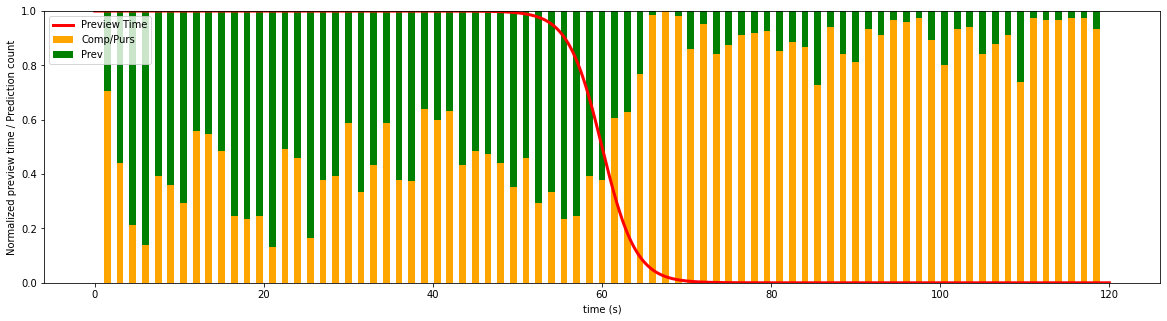

Total samples 11850 , Comp: 57.21 %, Prev: 42.79 %


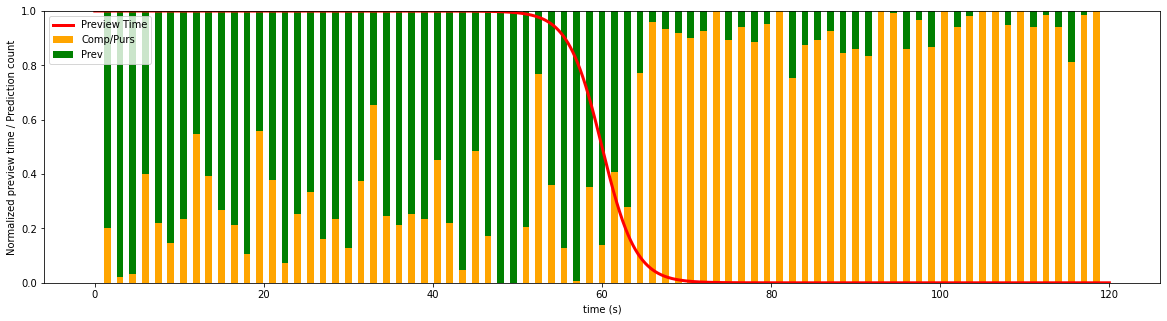

Total samples 11850 , Comp: 54.62 %, Prev: 45.38 %


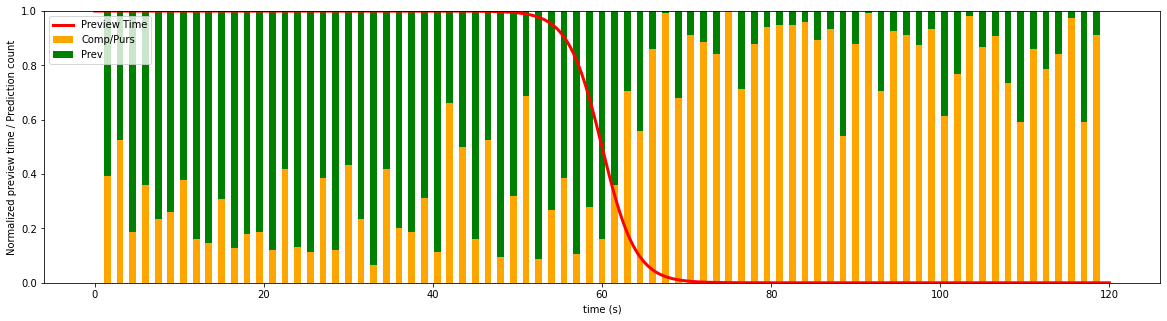

In [12]:
for cond in ['PRL', 'PRM', 'PRH']:
    analyse_cats(False, time_steps_between_samples=5, desired_conditions=[cond])

0 PRH


Total samples 7110 , Comp: 56.27 %, Prev: 43.73 %


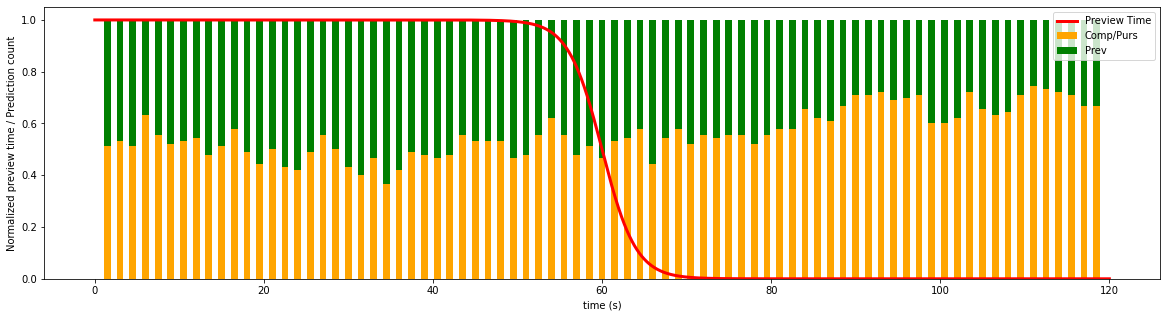

1 PRH


Total samples 7110 , Comp: 85.99 %, Prev: 14.01 %


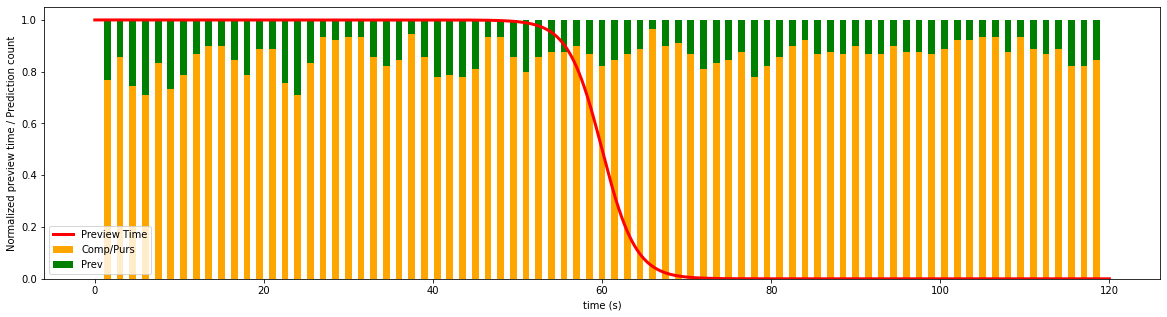

2 PRH


Total samples 7110 , Comp: 33.92 %, Prev: 66.08 %


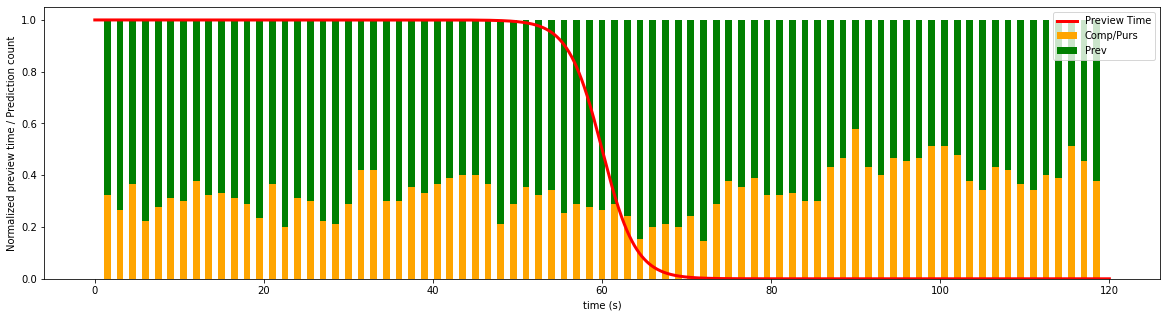

3 PRH


Total samples 7110 , Comp: 62.28 %, Prev: 37.72 %


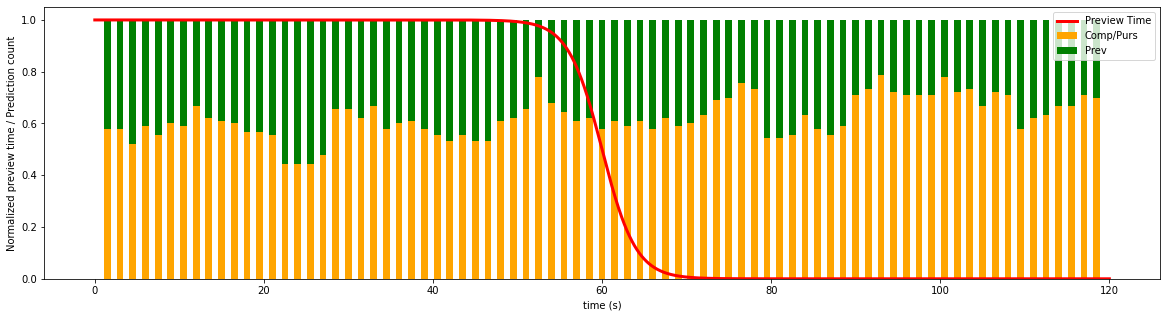

4 PRH


Total samples 7110 , Comp: 54.74 %, Prev: 45.26 %


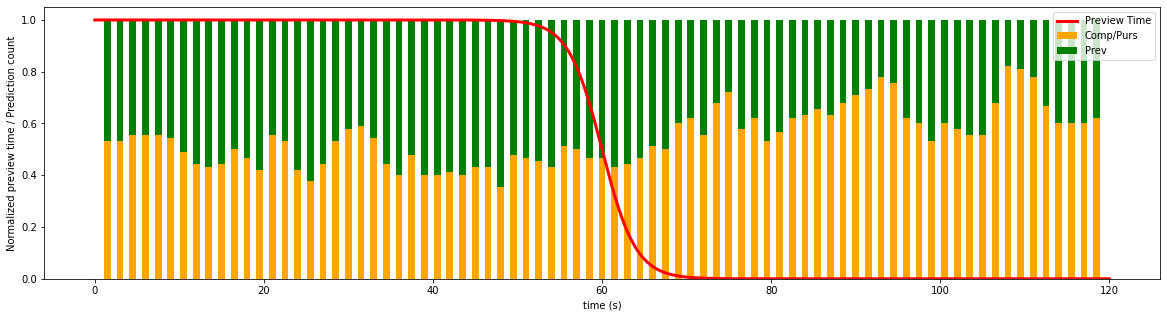

In [11]:
for subj in [0, 1, 2, 3, 4]:
    print(subj, cond)
    analyse_cats(False, time_steps_between_samples=5, subj_indices=[subj])

0 PRL


Total samples 2370 , Comp: 66.58 %, Prev: 33.42 %


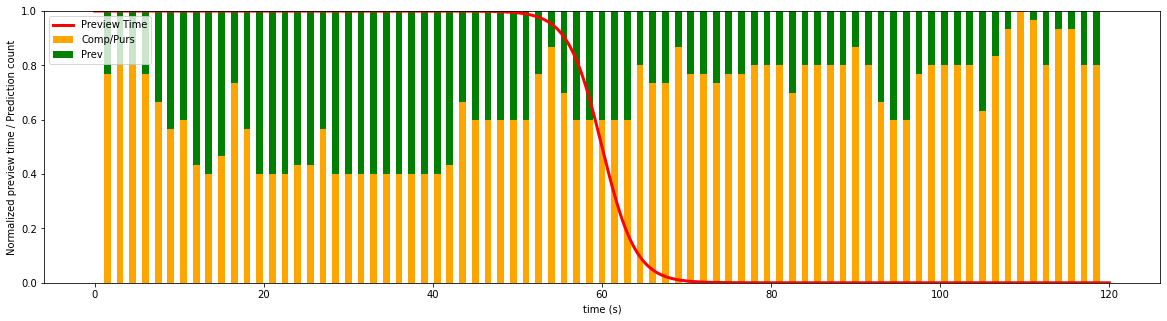

0 PRM


Total samples 2370 , Comp: 52.03 %, Prev: 47.97 %


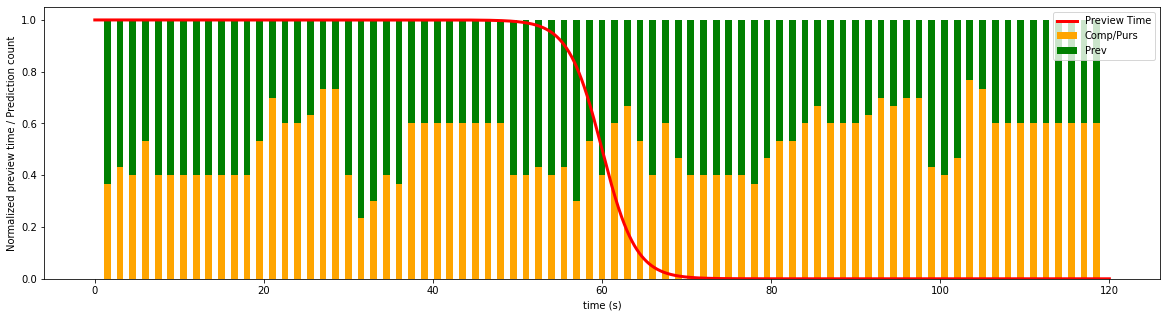

0 PRH


Total samples 2370 , Comp: 50.21 %, Prev: 49.79 %


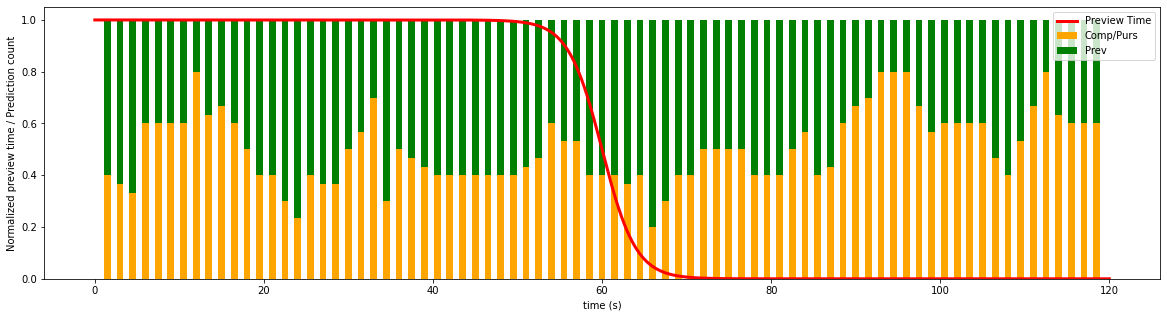

1 PRL


Total samples 2370 , Comp: 96.20 %, Prev: 3.80 %


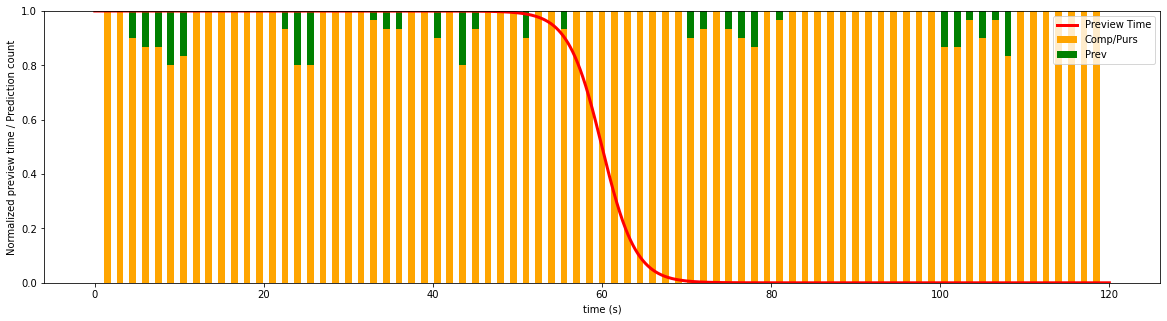

1 PRM


Total samples 2370 , Comp: 79.75 %, Prev: 20.25 %


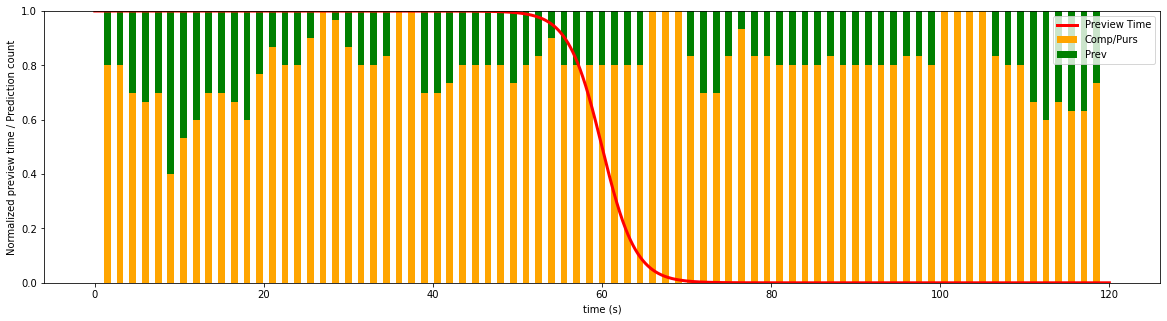

1 PRH


Total samples 2370 , Comp: 82.03 %, Prev: 17.97 %


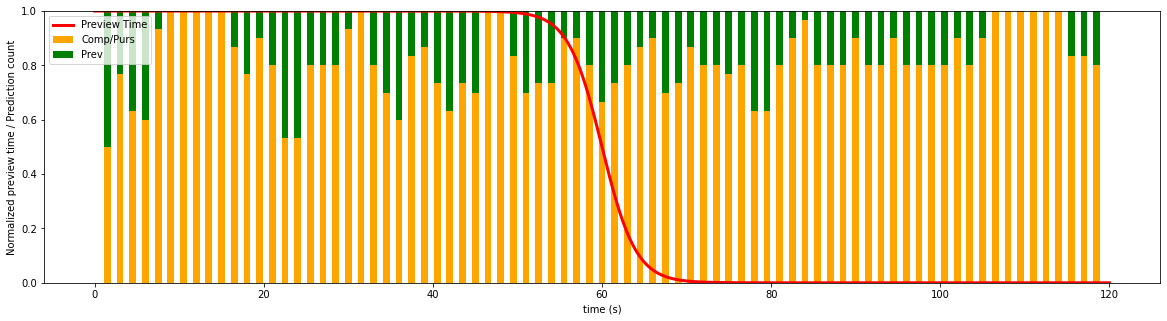

2 PRL


Total samples 2370 , Comp: 30.72 %, Prev: 69.28 %


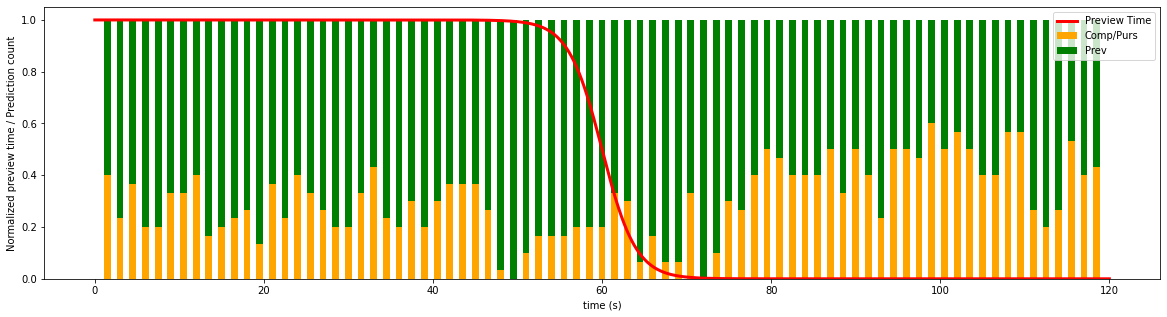

2 PRM


Total samples 2370 , Comp: 35.78 %, Prev: 64.22 %


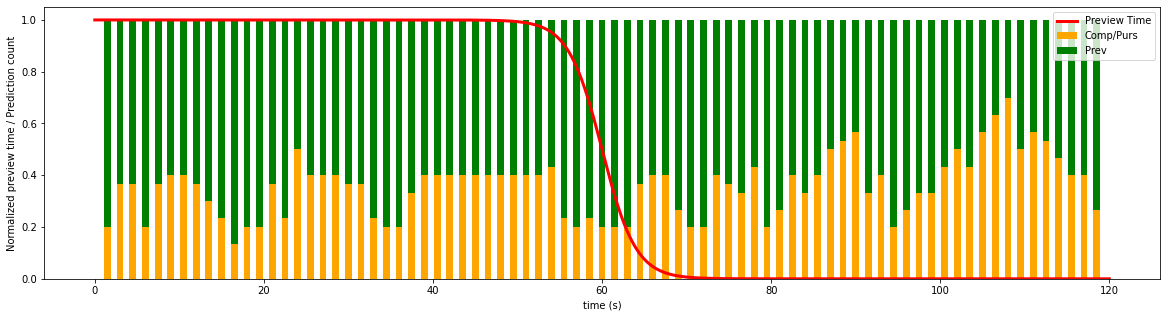

2 PRH


Total samples 2370 , Comp: 35.27 %, Prev: 64.73 %


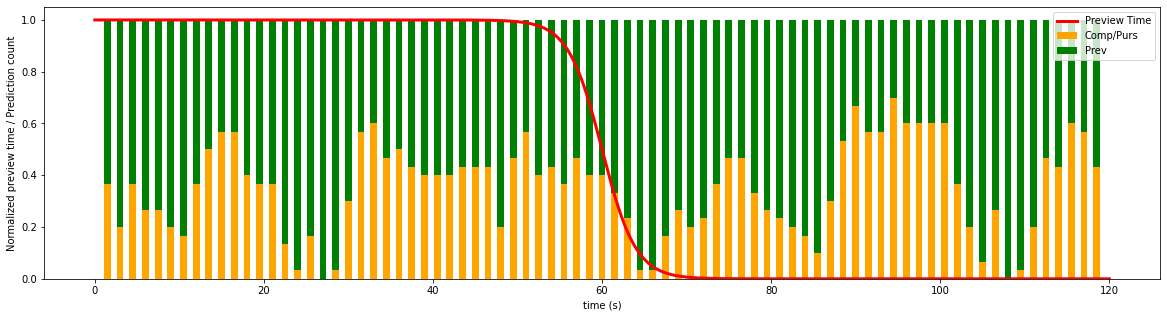

3 PRL


Total samples 2370 , Comp: 77.72 %, Prev: 22.28 %


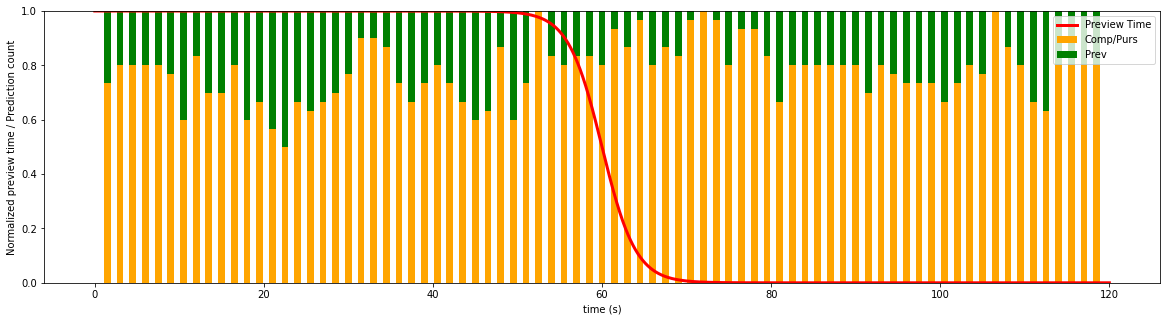

3 PRM


Total samples 2370 , Comp: 62.78 %, Prev: 37.22 %


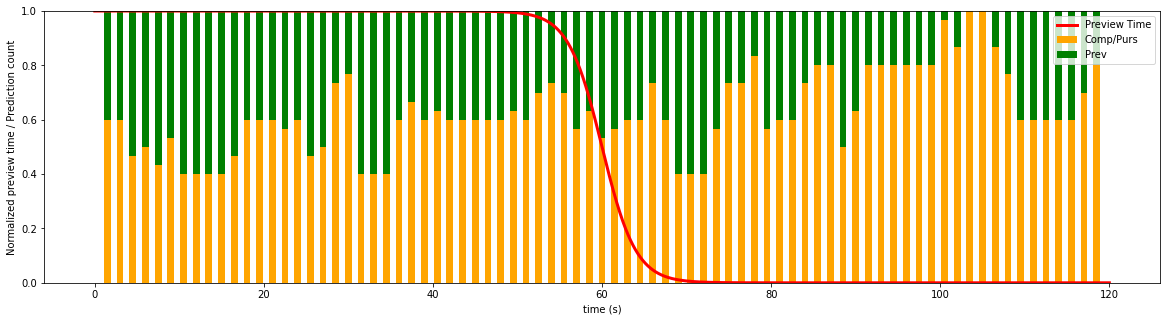

3 PRH


Total samples 2370 , Comp: 46.33 %, Prev: 53.67 %


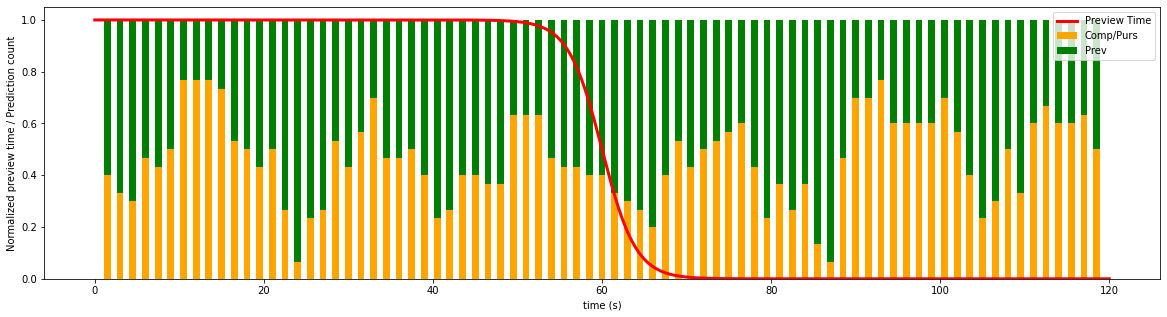

4 PRL


Total samples 2370 , Comp: 49.28 %, Prev: 50.72 %


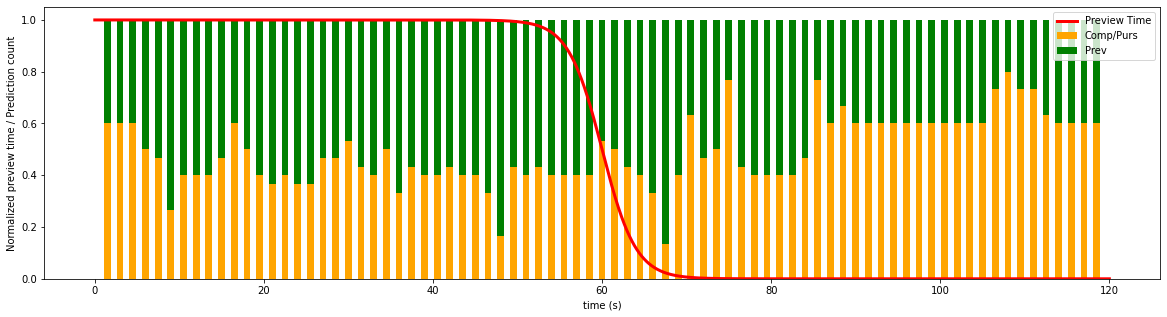

4 PRM


Total samples 2370 , Comp: 55.70 %, Prev: 44.30 %


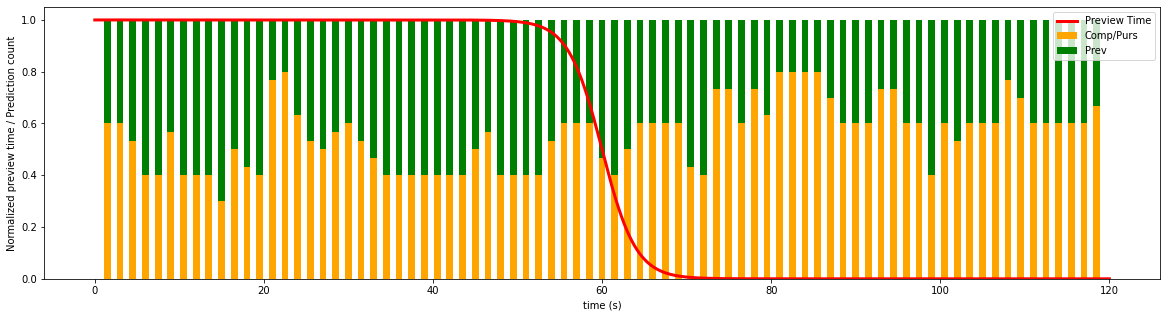

4 PRH


Total samples 2370 , Comp: 59.24 %, Prev: 40.76 %


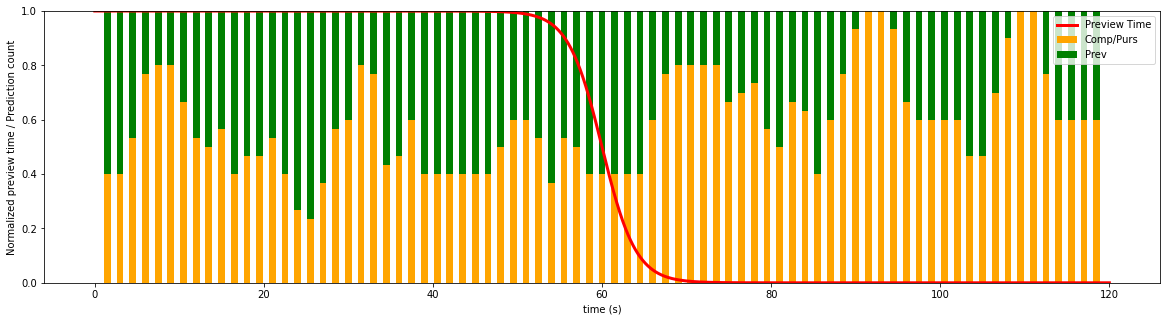

In [13]:
for subj, cond in it.product([0, 1, 2, 3, 4], ['PRL', "PRM", 'PRH']):
    print(subj, cond)
    analyse_cats(False, time_steps_between_samples=5, desired_conditions=[cond], subj_indices=[subj])

Total samples 35550 , Comp: 58.64 %, Prev: 41.36 %


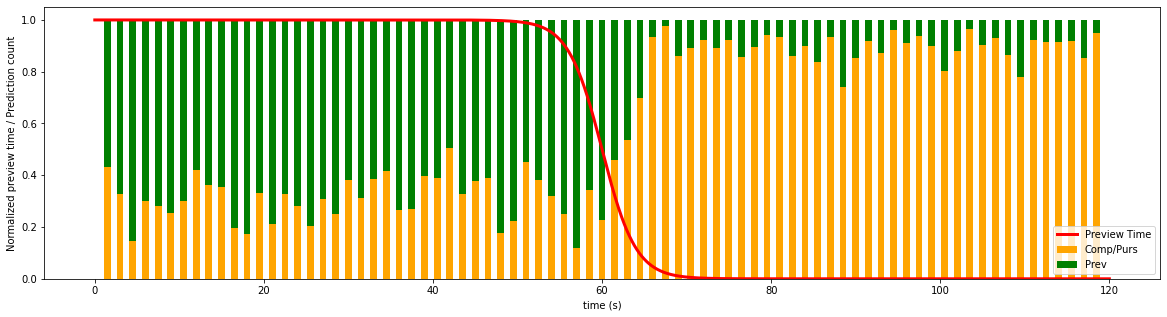

In [14]:
analyse_cats(False, time_steps_between_samples=5)

Total samples 35550 , Comp: 18.75 %, Purs: 35.97 %, Prev: 45.28 %


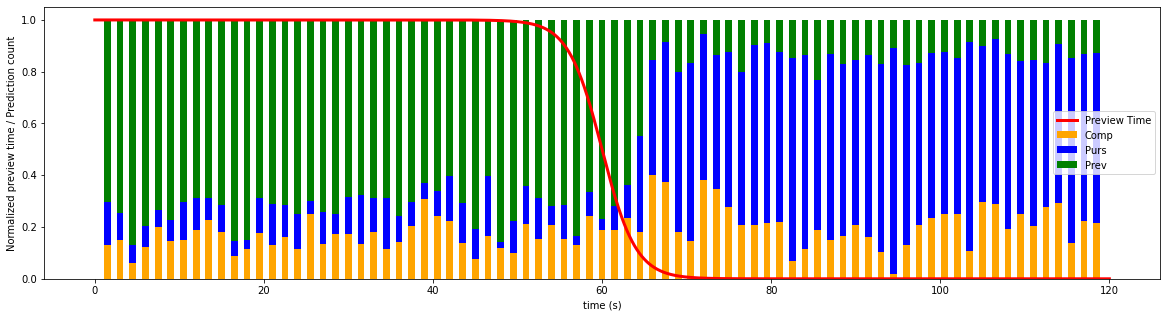

In [15]:
analyse_cats(True, time_steps_between_samples=5)

Total samples 35550 , Comp: 18.75 %, Purs: 35.97 %, Prev: 45.28 %


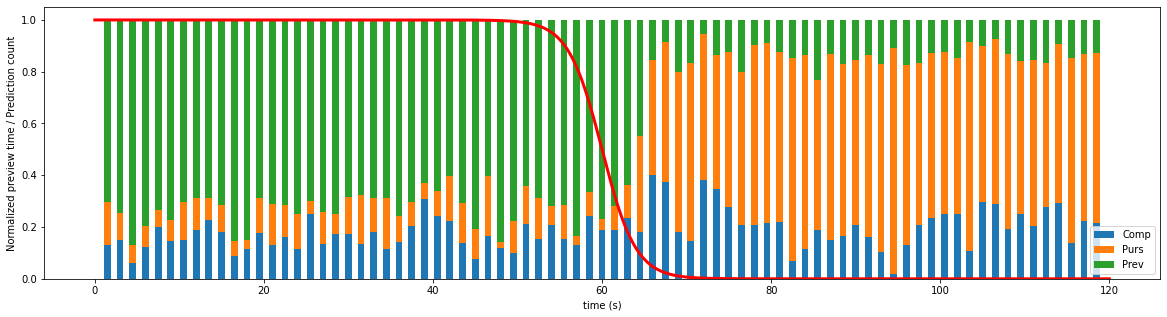

In [24]:
analyse_cats(True, time_steps_between_samples=5)

PRL


Total samples 59250 , Comp: 64.11 %, Prev: 35.89 %


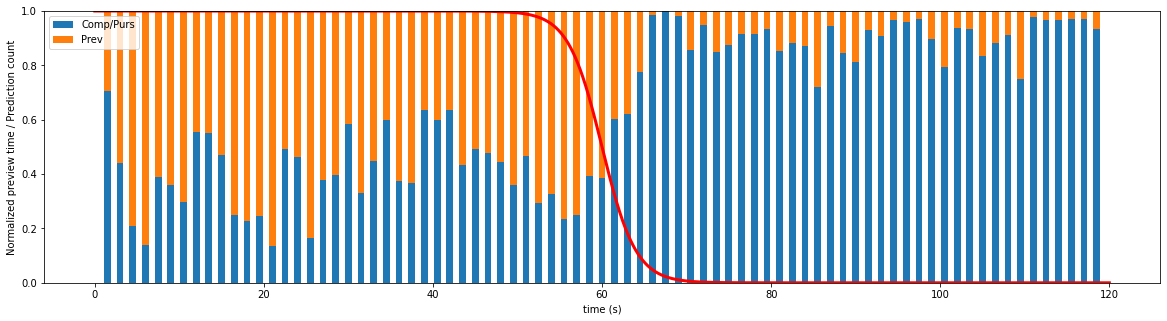

PRM


Total samples 59250 , Comp: 57.17 %, Prev: 42.83 %


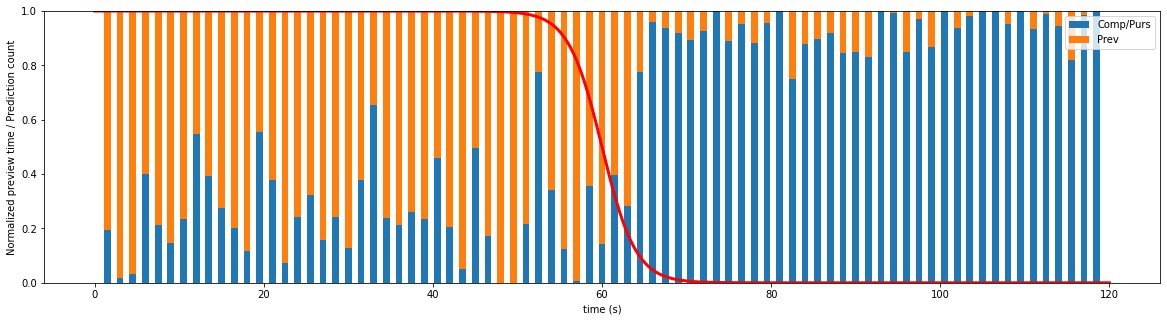

PRH


Total samples 59250 , Comp: 54.69 %, Prev: 45.31 %


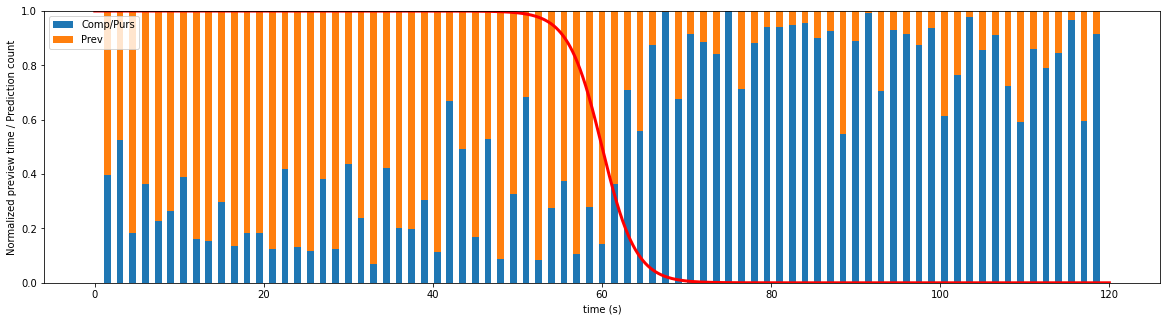

In [25]:
for cond in ['PRL', 'PRM', 'PRH']:
    print(cond)
    # analyse_cats(True, desired_conditions=[cond])
    analyse_cats(False, desired_conditions=[cond])

Total samples 177750 , Comp: 18.76 %, Purs: 36.02 %, Prev: 45.23 %


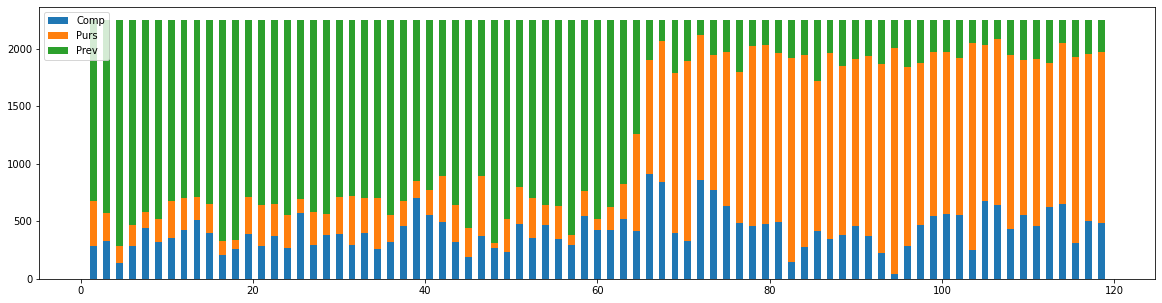

Total samples 177750 , Comp: 58.66 %, Prev: 41.34 %


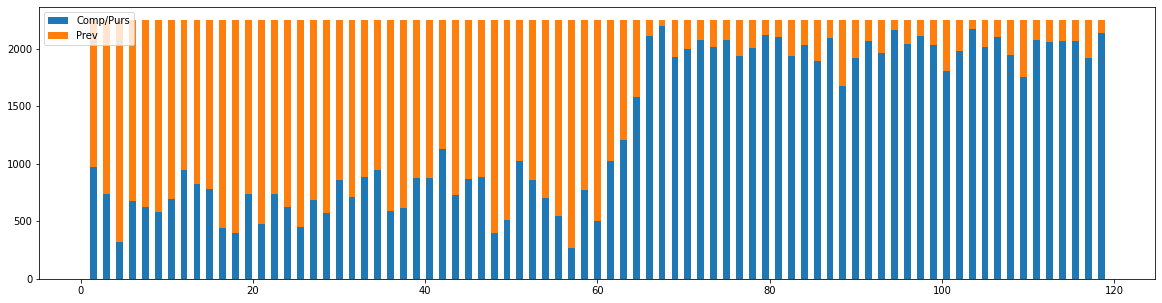

(None, None)

In [159]:
analyse_cats(cats_3class, True), analyse_cats(cats_2class, False)

In [55]:
test_cats = cats_3class.numpy()

In [110]:
np.vstack(np.split(test_cats, 15)).reshape(15, 79, -1)[0, 70]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [139]:
count_per_group_per_run = np.apply_along_axis(lambda sample_group:
                        np.array([count_of_elements_equal_to(sample_group, condition) for condition in [0.0, 1.0, 2.0]]), 2,
                    np.vstack(np.split(test_cats, 15)).reshape(15, 79, -1))

In [145]:
all_runs_sum = count_per_group_per_run.sum(axis=0).transpose()

In [124]:
one_run = count_per_group_per_run[0].transpose()

In [133]:
one_run.shape

(3, 79)

[[ 287  328  137  286  443  324  353  422  511  402  207  255  392  281
   373  264  570  295  380  388  296  398  258  324  456  703  554  497
   323  187  371  269  229  474  353  464  347  297  542  424  425  524
   414  911  840  395  327  860  769  631  481  463  478  494  149  273
   413  343  384  458  368  225   43  289  468  550  560  554  250  678
   638  437  553  455  624  650  310  506  485]
 [ 387  246  150  180  141  195  325  280  201  247  125   86  323  364
   281  290  121  285  180  326  424  301  441  232  218  145  215  395
   318  257  523   46  287  327  349  178  285   84  222   99  201  299
   842  994 1225 1398 1563 1259 1177 1341 1316 1563 1556 1470 1767 1669
  1310 1621 1469 1450 1572 1640 1960 1555 1411 1422 1410 1362 1802 1351
  1450 1510 1350 1455 1255 1399 1614 1447 1483]
 [1576 1676 1963 1784 1666 1731 1572 1548 1538 1601 1918 1909 1535 1605
  1596 1696 1559 1670 1690 1536 1530 1551 1551 1694 1576 1402 1481 1358
  1609 1806 1356 1935 1734 1449 1548 160

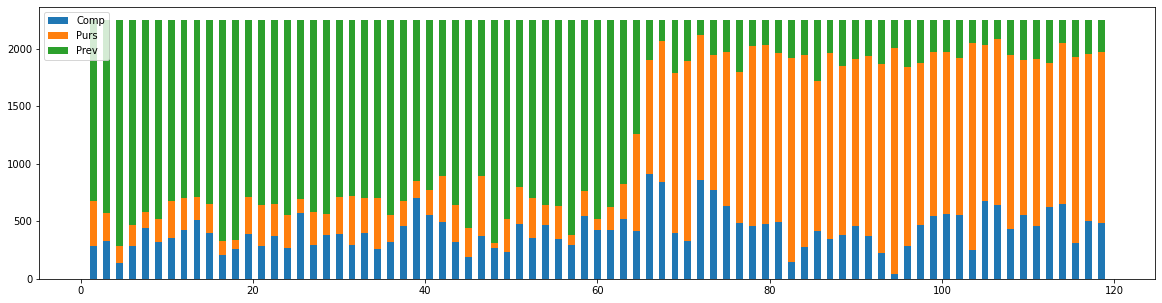

(79, 3)

In [147]:
all_runs_sum.transpose().shape

In [96]:
split_stacked.shape

(15, 79, 150)

In [89]:
df = pd.DataFrame(columns=['preds'])
df['preds'] = df['preds'].astype(object)
df['preds'] = split_stacked
df.apply(lambda row: print(row.shape), raw=True)

(15,)


preds    None
dtype: object

In [76]:
df.head()

,preds
0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]"
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]"
3,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]"


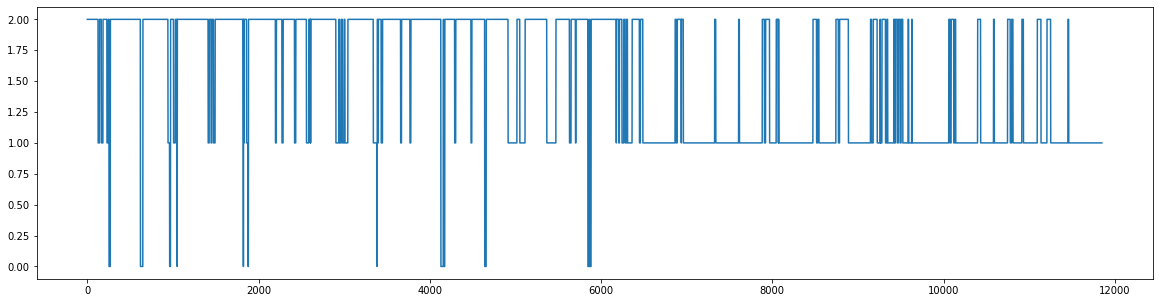

In [68]:
plt.plot(np.hstack(split_stacked[13]))

In [42]:
cats_3class[cats_3class == 0.0].shape, cats_3class[cats_3class == 1.0].shape, cats_3class[cats_3class == 2.0].shape, cats_3class.shape

(torch.Size([33339]),
 torch.Size([64017]),
 torch.Size([80394]),
 torch.Size([177750]))

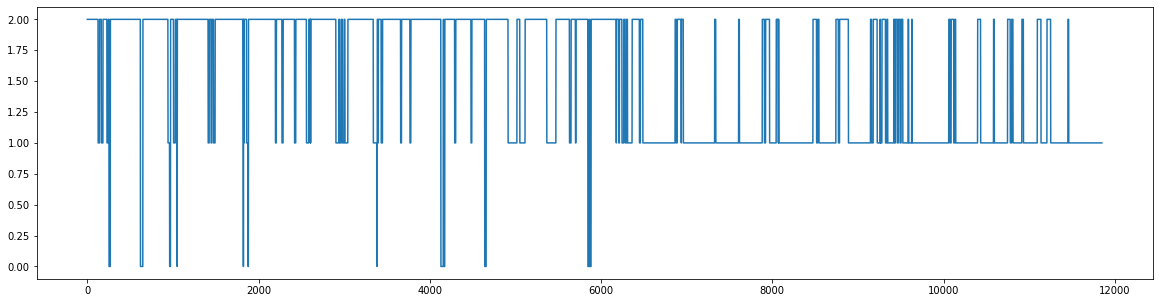

In [69]:
samples_per_run = 11850
# for i in range(0, 3):
for i in [13]:
    plt.plot(cats_3class[i * samples_per_run:(1 + i) * samples_per_run])


In [24]:
# 0 errors on comp, 1 error on PS, 1 error on PR

In [ ]:
# Loading normal SI data - backup
    kwargs_norm = {
        "file": Path('data', 'expdata_SI.mat'),
        "desired_conditions": ['PRH'],
        "subj_indices": [0, 1, 2, 3, 4, 5, 6, 7, 8],
        "run_indices": [0, 1, 2, 3, 4]
    }

    X_norm = get_var_prev_data(**kwargs_norm)

    dls = learner.dls
    valid_dl = dls.valid

    norm_ds = dls.dataset.add_test(X_norm)
    norm_dl = valid_dl.new(norm_ds, shuffle=False)

    test_probas, test_preds = learner.get_preds(dl=norm_dl)
    categories = torch.argmax(test_probas, dim=1)
    return categories